In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, multi_dot
from scipy.stats import norm
from tabulate import tabulate

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

In [12]:
# load data
data = pd.read_csv('Data_SP500.csv')

# calculate returns
returns = np.zeros(1250)
returns[1:] = data['SP500'].pct_change().dropna()
data['returns'] = returns



<AxesSubplot:xlabel='Date'>

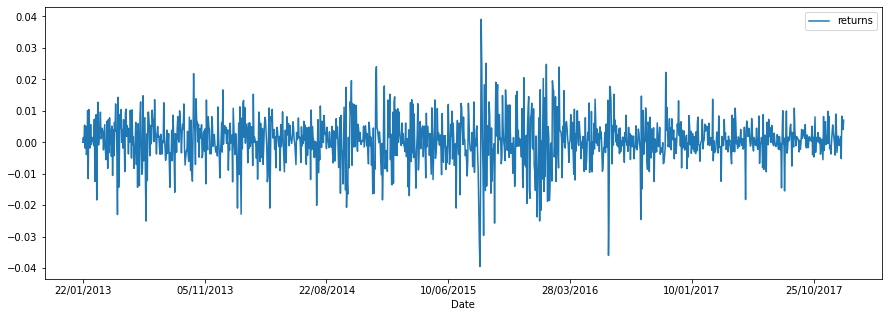

In [21]:
# plot the returns
data.plot(x="Date", y='returns', figsize=(15,5))


In [22]:
# calculate 21 day rolling standard deviation
std_21 = data['SP500'].pct_change().rolling(21).std()
data['std_21'] = std_21

# calculate VaR for 21 day window vol
def calc_var(std):
    ans = norm.ppf(1-0.99)*std*(10**0.5)
    return ans
data['var_99'] =  data['std_21'].rolling(1).apply(lambda x: calc_var(x))

# compute actual VaR
data['var_actual'] = data['SP500'] * data['var_99']

# compute 10 day difference
data['10day_change'] = data['SP500']* np.log(data['SP500']/data['SP500'].shift(10))
data['breached'] = np.where(data['10day_change'] < data['var_actual'].shift(10), 1, 0)



In [79]:
# Var breaches
breaches = np.zeros(1250)

for i in range(21, 1240):
    x = data['SP500'][i+10]
    y = data['SP500'][i]
    diff =  x - y if x < y else 0

    if diff < data['var_actual'][i]:
        breaches[i+10] = 1
    else:
        breaches[i+10] = 0

 # percentage breaches
total_breaches = breaches.sum()
total_measurements = len(breaches[21:1240])
pct_breaches = (total_breaches/total_measurements)*100
print(f"The percentage breaches is {np.round(pct_breaches, 2)}%")

# consecutive breaches
from itertools import groupby
def groups(l):
    return [(sum(g) -1 ) for i, g in groupby(l) if i == 1]

num = np.sum(groups(breaches))
print(f"The total number of consecutive breaches: {num}")


The percentage breaches is 2.05%
The total number of consecutive breaches: 14.0


In [80]:
data['breached'] = breaches
breaches_data = data[data['breached'] == 1]

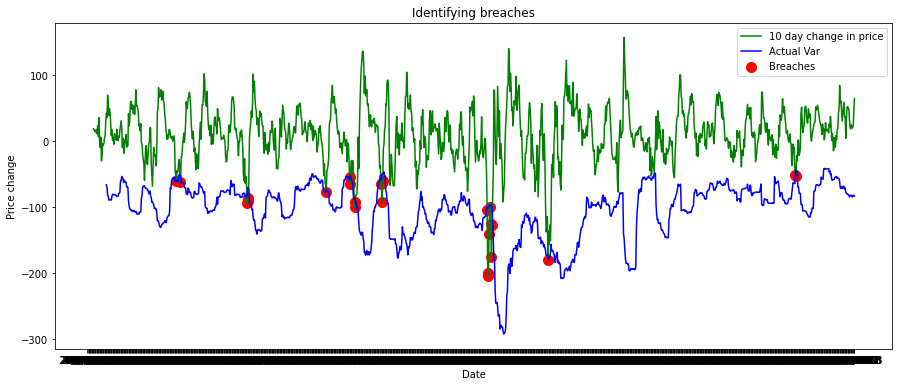

In [84]:
# visualize the VaR breaches
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(data.Date, data['10day_change'], c = 'green')
ax.plot(data.Date, data.var_actual.shift(10), c = 'blue')
ax.scatter(breaches_data.Date, breaches_data['10day_change'], c ='red', s = 100)

# add a legend
plt.ylabel('Price change')
plt.xlabel('Date')
plt.legend(['10 day change in price', 'Actual Var', 'Breaches'])
plt.title('Identifying breaches')
plt.show()

In [40]:
# compute EWMA VaR

def ewma_vol(prev_vol, curr_ret, l = 0.72):
    vol = l*(prev_vol**2) + (1-l)*(curr_ret**2)
    return np.sqrt(vol)

std_ewma = np.zeros(1250)

for i in range(22, 1240):
    std_ewma[i]= ewma_vol(std_21[i-1], returns[i])

data['std_ewma'] = std_ewma



In [45]:
# compute VaR_99 using EWMA method
data["VaR_99_ewma"] = data['std_ewma'].rolling(1).apply(lambda x: calc_var(x))

# compute actual VaR using ewma
data["VaR_ewma_actual"] = data['SP500'] * data['VaR_99_ewma']

In [85]:
# Var EWMA breaches
breaches = np.zeros(1250)

for i in range(21, 1240):
    x = data['SP500'][i+10]
    y = data['SP500'][i]
    diff =  x - y if x < y else 0

    if diff < data['VaR_ewma_actual'][i]:
        breaches[i+10] = 1
    else:
        breaches[i+10] = 0

# percentage breaches
total_breaches = breaches.sum()
total_measurements = len(breaches[21:1240])
pct_breaches = (total_breaches/total_measurements)*100
print(f"The percentage breaches (Using EWMA VaR): {np.round(pct_breaches, 2)}%")

# consecutive breaches
from itertools import groupby
def groups(l):
    return [(sum(g) -1 ) for i, g in groupby(l) if i == 1]

num = np.sum(groups(breaches))
print(f"The total number of consecutive breaches (Using EWMA VaR): {num}")

The percentage breaches (Using EWMA VaR): 2.3%
The total number of consecutive breaches (Using EWMA VaR): 14.0


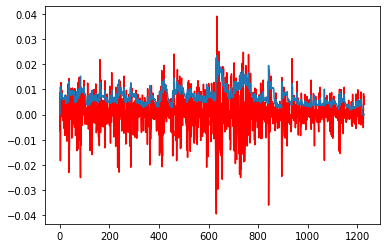

In [48]:

plt.plot(returns[21:], color='red')
plt.plot(std_ewma[21:])
plt.show()

In [86]:
data['breached'] = breaches
breaches_data = data[data['breached'] == 1]


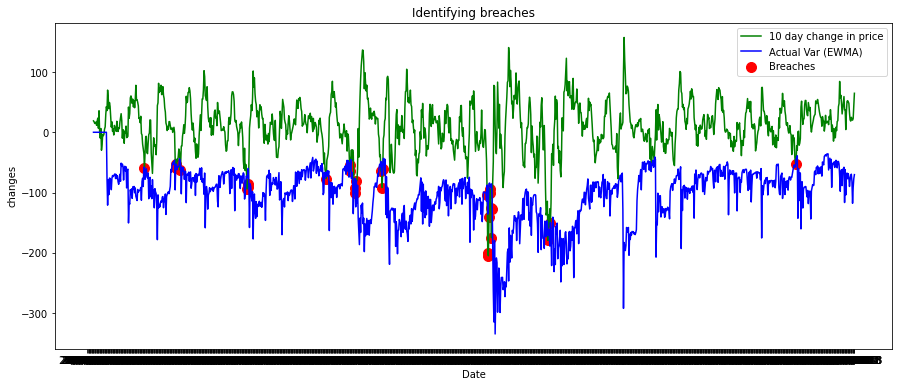

In [87]:
fig, ax = plt.subplots(figsize=(15, 6))

colors = {0:'tab:green', 1:'tab:red'}

ax.plot(data.Date, data['10day_change'], c = 'green')
ax.plot(data.Date, data.VaR_ewma_actual.shift(10), c = 'blue')
ax.scatter(breaches_data.Date, breaches_data['10day_change'], c ='red', s = 100)

# add a legend
plt.ylabel('changes')
plt.xlabel('Date')
plt.legend(['10 day change in price', 'Actual Var (EWMA)', 'Breaches'])
plt.title('Identifying breaches')
plt.show()
